2025-05-08 16:17:49.992238: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-05-08 16:17:49.992257: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-08 16:17:49.992261: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1746713869.992544   37680 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1746713869.992573   37680 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2025-05-08 16:17:51.583088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-05-08 16:17:52.516169: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


313/313 ━━━━━━━━━━━━━━━━━━━━ 428s 1s/step - accuracy: 0.2039 - loss: 6.6442 - val_accuracy: 0.6288 - val_loss: 1.7460
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 454s 1s/step - accuracy: 0.5103 - loss: 3.3807 - val_accuracy: 0.6678 - val_loss: 1.6707
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 484s 2s/step - accuracy: 0.5663 - loss: 2.7554 - val_accuracy: 0.6751 - val_loss: 1.6174
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 481s 2s/step - accuracy: 0.5962 - loss: 2.3863 - val_accuracy: 0.6815 - val_loss: 1.5796
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 499s 2s/step - accuracy: 0.6114 - loss: 2.1706 - val_accuracy: 0.6889 - val_loss: 1.5065
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 484s 2s/step - accuracy: 0.6268 - loss: 2.0052 - val_accuracy: 0.6819 - val_loss: 1.5465
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 489s 2s/step - accuracy: 0.6387 - loss: 1.9034 - val_accuracy: 0.6802 - val_loss: 1.5126
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 455s 1s/step - accuracy: 0.6458 - loss: 1.8238 - val_accuracy: 0.694

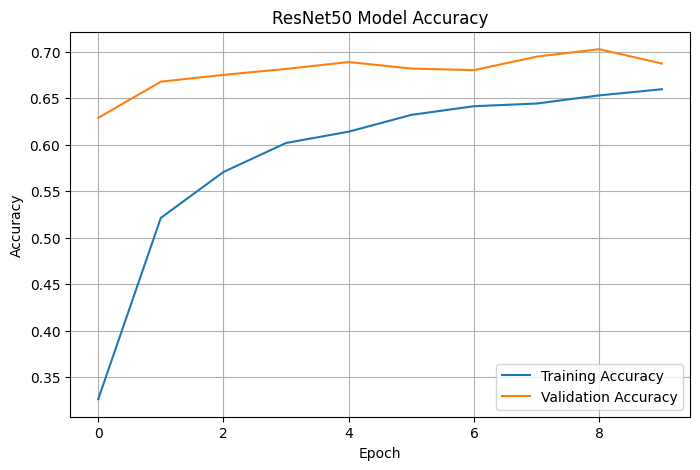

Final Validation Accuracy (ResNet50): 68.73%


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

# Load the CIFAR-100 dataset
(ds_train, ds_val), ds_info = tfds.load(
    "cifar100",
    split=["train[:80%]", "train[80%:]"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Get class names
class_names = ds_info.features['label'].names
num_classes = len(class_names)

# Preprocessing functions
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize for ResNet
    image = tf.keras.applications.resnet50.preprocess_input(image)
    label = tf.one_hot(label, depth=num_classes)
    return image, label

batch_size = 128

train_ds = ds_train.map(preprocess).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = ds_val.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Build the model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')
base_model.trainable = False  # Freeze base model

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
final_val_acc = history.history['val_accuracy'][-1] * 100
print(f"Final Validation Accuracy (ResNet50): {final_val_acc:.2f}%")
